In [1]:
from transformers import BertTokenizer, BertForMaskedLM, Trainer, TrainingArguments, TrainerCallback
from transformers import DataCollatorForLanguageModeling
from torch.utils.data import DataLoader
import torch
import random
import os

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForMaskedLM.from_pretrained('bert-base-cased')

# Read the Othello text data from file
with open('sample.txt', 'r') as file:
    text_data = file.read().splitlines()
    # Only read the first 100 lines
    # text_data = text_data[:10]

# Tokenize all texts
inputs = tokenizer(text_data, return_tensors="pt", max_length=512, truncation=True, padding="max_length", return_attention_mask=True)

# Use a data collator for MLM
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

# Create a torch dataset
class OthelloData(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

dataset = OthelloData(inputs)

# Print some examples
print(tokenizer.decode(dataset[0]['input_ids']))


c:\Users\echo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\echo\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassifi

[CLS] Hen in a house is safe from the fox. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

C:\Users\echo\AppData\Local\Temp\ipykernel_12296\1350230938.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [2]:
# Check if tensorflow detects gpu
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")

GPU is available


In [3]:

def compress_text(text, tokenizer, mask_probability=0.15):
    tokens = tokenizer.tokenize(text)
    # Decide which tokens to mask based on a simple probability check
    masked_tokens = [
        tokenizer.mask_token if random.random() < mask_probability else token
        for token in tokens
    ]
    compressed_text = tokenizer.convert_tokens_to_string(masked_tokens)
    return compressed_text

def decompress_text(compressed_text, model, tokenizer):
    # Tokenize the text and identify masked indices
    inputs = tokenizer(compressed_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    mask_token_index = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)
    masked_indices = torch.where(inputs['input_ids'] == mask_token_index)[1]

    # Predict masked tokens with BERT
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Replace masked tokens with the most probable prediction
    input_ids = inputs['input_ids'].tolist()[0]
    for idx in masked_indices:
        predicted_token_id = logits[0, idx].argmax(axis=-1).item()
        input_ids[idx] = predicted_token_id

    # Convert token IDs back to text
    decompressed_text = tokenizer.decode(input_ids, skip_special_tokens=True)
    return decompressed_text

In [4]:
def decompress_texts_for_model(model_name, compressed_texts, original_texts):
    # Load the fine-tuned model and tokenizer
    model = BertForMaskedLM.from_pretrained(model_name)
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

    decompressed_texts = []
    for compressed_text in compressed_texts:
        decompressed_text = decompress_text(compressed_text, model, tokenizer)
        decompressed_texts.append(decompressed_text)

    accuracies = []
    for original, decompressed in zip(original_texts, decompressed_texts):
        accuracy = int(original == decompressed)
        accuracies.append(accuracy)

    return decompressed_texts, accuracies

In [5]:
class SaveModelCallback(TrainerCallback):
    def __init__(self, save_steps):
        super().__init__()
        self.save_steps = save_steps

    def on_epoch_end(self, args, state, control, **kwargs):
        if state.epoch in self.save_steps:
            epoch = int(state.epoch)
            model_path = f"./Othello_bert{epoch}"
            os.makedirs(model_path, exist_ok=True)
            kwargs['model'].save_pretrained(model_path)
            print(f"Model saved to {model_path} at epoch {epoch}")

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=100,  # max epochs
    per_device_train_batch_size=8,
    logging_dir='./logs',
    logging_steps=10,
)

model = BertForMaskedLM.from_pretrained('bert-base-cased')

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
    callbacks=[SaveModelCallback(save_steps=[1, 3, 5, 10, 25, 50, 100])],  # epochs to save
)

trainer.train()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\echo\AppData\Local\Temp\ipykernel_12296\1350230938.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key

Model saved to ./Othello_bert1 at epoch 1


  3%|▎         | 3/100 [00:00<00:25,  3.76it/s]C:\Users\echo\AppData\Local\Temp\ipykernel_12296\1350230938.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
  4%|▍         | 4/100 [00:01<00:30,  3.15it/s]

Model saved to ./Othello_bert3 at epoch 3


  5%|▌         | 5/100 [00:01<00:23,  4.01it/s]C:\Users\echo\AppData\Local\Temp\ipykernel_12296\1350230938.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
  6%|▌         | 6/100 [00:01<00:28,  3.34it/s]

Model saved to ./Othello_bert5 at epoch 5


 10%|█         | 10/100 [00:02<00:14,  6.04it/s]

{'loss': 1.8882, 'grad_norm': 17.29289436340332, 'learning_rate': 4.5e-05, 'epoch': 10.0}


C:\Users\echo\AppData\Local\Temp\ipykernel_12296\1350230938.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
 11%|█         | 11/100 [00:02<00:21,  4.10it/s]

Model saved to ./Othello_bert10 at epoch 10


 21%|██        | 21/100 [00:04<00:10,  7.52it/s]

{'loss': 0.8746, 'grad_norm': 2.838857889175415, 'learning_rate': 4e-05, 'epoch': 20.0}


 25%|██▌       | 25/100 [00:04<00:09,  7.77it/s]C:\Users\echo\AppData\Local\Temp\ipykernel_12296\1350230938.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
 26%|██▌       | 26/100 [00:04<00:16,  4.59it/s]

Model saved to ./Othello_bert25 at epoch 25


 31%|███       | 31/100 [00:05<00:10,  6.86it/s]

{'loss': 0.5754, 'grad_norm': 18.9520320892334, 'learning_rate': 3.5e-05, 'epoch': 30.0}


 41%|████      | 41/100 [00:06<00:07,  7.61it/s]

{'loss': 0.0532, 'grad_norm': 13.452214241027832, 'learning_rate': 3e-05, 'epoch': 40.0}


 50%|█████     | 50/100 [00:08<00:06,  7.78it/s]

{'loss': 0.2111, 'grad_norm': 0.0027603425551205873, 'learning_rate': 2.5e-05, 'epoch': 50.0}


C:\Users\echo\AppData\Local\Temp\ipykernel_12296\1350230938.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
 51%|█████     | 51/100 [00:08<00:10,  4.53it/s]

Model saved to ./Othello_bert50 at epoch 50


 61%|██████    | 61/100 [00:09<00:05,  7.51it/s]

{'loss': 0.7181, 'grad_norm': 0.31968313455581665, 'learning_rate': 2e-05, 'epoch': 60.0}


 71%|███████   | 71/100 [00:11<00:03,  7.64it/s]

{'loss': 0.1381, 'grad_norm': 0.017793456092476845, 'learning_rate': 1.5e-05, 'epoch': 70.0}


 81%|████████  | 81/100 [00:12<00:02,  7.10it/s]

{'loss': 0.3961, 'grad_norm': 63.058048248291016, 'learning_rate': 1e-05, 'epoch': 80.0}


 91%|█████████ | 91/100 [00:13<00:01,  7.66it/s]

{'loss': 0.2095, 'grad_norm': 0.1997428685426712, 'learning_rate': 5e-06, 'epoch': 90.0}


100%|██████████| 100/100 [00:14<00:00,  7.85it/s]

{'loss': 0.0709, 'grad_norm': 0.00021161492622923106, 'learning_rate': 0.0, 'epoch': 100.0}


100%|██████████| 100/100 [00:15<00:00,  6.62it/s]

Model saved to ./Othello_bert100 at epoch 100
{'train_runtime': 15.1206, 'train_samples_per_second': 26.454, 'train_steps_per_second': 6.613, 'train_loss': 0.5135204786062241, 'epoch': 100.0}


TrainOutput(global_step=100, training_loss=0.5135204786062241, metrics={'train_runtime': 15.1206, 'train_samples_per_second': 26.454, 'train_steps_per_second': 6.613, 'total_flos': 105280049971200.0, 'train_loss': 0.5135204786062241, 'epoch': 100.0})

['[MASK]n in a house is [MASK] from [MASK] fox .', 'Hen in a house is safe from the fox .', 'A lazy [MASK] [MASK] over the quick brown fox .', '[MASK] house without hens is [MASK] lonely place .', 'A lazy dog jumps over the quick brown fox [MASK]', 'A lazy dog jumps over the quick brown fox [MASK]', 'Hen [MASK] a house is safe from the fox [MASK]', 'A lazy dog jumps over the quick brown fox [MASK]', 'Hen in a house is safe from the fox .', 'Hen in a [MASK] is safe from the fox .', 'A [MASK] dog jumps over the quick brown fox .', 'Hen [MASK] a house is safe from the [MASK] .', 'Hen [MASK] a house is safe from the fox .', 'A lazy dog jumps over the quick [MASK] [MASK] .', '[MASK] lazy [MASK] [MASK] [MASK] the quick brown fox .', 'A house without [MASK]ns is a lonely [MASK] .', '[MASK]n in [MASK] house is [MASK] from the fox [MASK]', '[MASK]n in a house is safe from the fox [MASK]', '[MASK] house without hens is a lonely place .', 'A lazy dog jumps over [MASK] quick brown fox .', 'He [MAS

c:\Users\echo\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model: Othello_bert1
Original: Hen in a house is safe from the fox.
Decompressed: A n in a house is safe from a fox.
Correct: False

Original: Hen in a house is safe from the fox.
Decompressed: Hen in a house is safe from the fox.
Correct: True

Original: A lazy dog jumps over the quick brown fox.
Decompressed: A lazy smile passed over the quick brown fox.
Correct: False

Original: A house without hens is a lonely place.
Decompressed: A house without hens is a lonely place.
Correct: True

Original: A lazy dog jumps over the quick brown fox.
Decompressed: A lazy dog jumps over the quick brown fox.
Correct: True

Original: A lazy dog jumps over the quick brown fox.
Decompressed: A lazy dog jumps over the quick brown fox.
Correct: True

Original: Hen in a house is safe from the fox.
Decompressed: Hen thinks a house is safe from the fox.
Correct: False

Original: A lazy dog jumps over the quick brown fox.
Decompressed: A lazy dog jumps over the quick brown fox.
Correct: True

Original: Hen

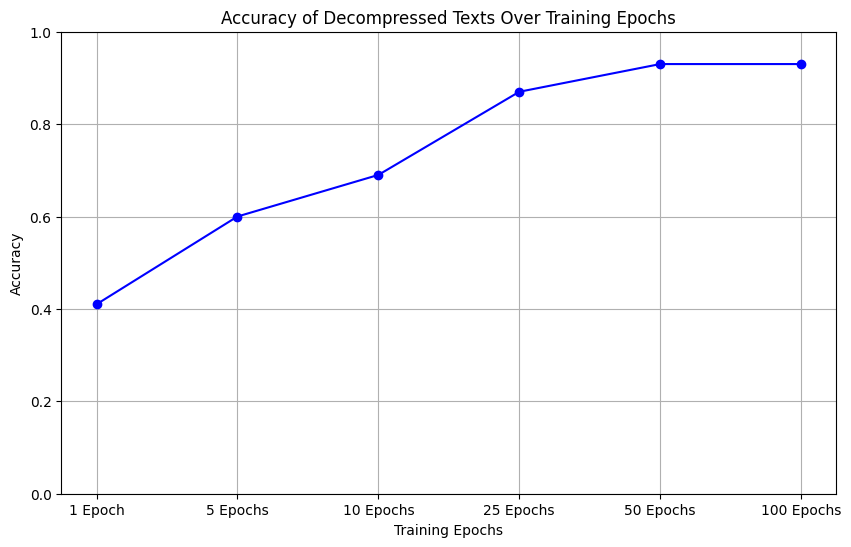

In [6]:
num_samples = 100
compressed_texts = []
original_texts = []

for _ in range(num_samples):
    random_index = random.randint(0, len(text_data) - 1)
    original_text = text_data[random_index]
    compressed_text = compress_text(original_text, tokenizer)
    compressed_texts.append(compressed_text)
    original_texts.append(original_text)

print(compressed_texts)

model_names = ['Othello_bert1', 'Othello_bert5', 'Othello_bert10', 'Othello_bert25', 'Othello_bert50', 'Othello_bert100']
accuracies = {}

for model_name in model_names:
    decompressed_texts, sample_accuracies = decompress_texts_for_model(model_name, compressed_texts, original_texts)
    print(f"Model: {model_name}")
    for original, decompressed in zip(original_texts, decompressed_texts):
        print(f"Original: {original}")
        print(f"Decompressed: {decompressed}")
        print(f"Correct: {original == decompressed}")
        print()

    accuracy = sum(sample_accuracies) / len(sample_accuracies)
    accuracies[model_name] = accuracy

print(accuracies)

import matplotlib.pyplot as plt

epochs = ['1 Epoch', '5 Epochs', '10 Epochs', '25 Epochs', '50 Epochs', '100 Epochs'] 
accuracy_values = list(accuracies.values())

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy_values, marker='o', linestyle='-', color='b')
plt.title('Accuracy of Decompressed Texts Over Training Epochs')
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid(True)
plt.show()

In [7]:
def compress_text(text, model, tokenizer, device, mask_probability=0.15):
    tokens = tokenizer.tokenize(text)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids_tensor = torch.tensor([input_ids]).to(device)

    # model's predictions
    with torch.no_grad():
        outputs = model(input_ids_tensor)
        predictions = outputs.logits.softmax(dim=-1)

    # Find indices of words w/ highest probs
    num_masks = max(int(len(tokens) * mask_probability), 1)
    mask_indices = predictions.argsort(dim=-1, descending=True)[0, :num_masks].squeeze().tolist()

    # Mask the tokens at indices
    masked_tokens = tokens.copy()
    for idx in mask_indices:
        masked_tokens[idx] = tokenizer.mask_token

    compressed_text = tokenizer.convert_tokens_to_string(masked_tokens)
    return compressed_text

In [53]:
import spacy
import torch
import random

# Load spaCy model for POS tagging
nlp = spacy.load("en_core_web_sm")

def advanced_compress_text(text, tokenizer, model, mask_ratio=0.15):
    """
    Masks tokens in text based on linguistic significance and model confidence.
    
    Args:
    - text (str): Original text to be compressed.
    - tokenizer: Pretrained tokenizer (from transformers).
    - model: Pretrained language model (from transformers).
    - mask_ratio (float): Ratio of tokens to mask.
    
    Returns:
    - str: Text with MASK tokens inserted.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # spaCy for POS tagging
    doc = nlp(text)
    tokens = [token.text for token in doc]
    pos_tags = [token.pos_ for token in doc]
    
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)['input_ids'].to(device)
    
    # model's prediction on which tokens are likely
    with torch.no_grad():
        outputs = model(input_ids)
        predictions = outputs.logits
    
    # confidence scores for each token
    confidence_scores = torch.max(torch.softmax(predictions, dim=-1), dim=-1)[0].squeeze()
    
    # mask based on POS tags
    preferred_tags = ['NOUN', 'VERB', 'ADJ']
    potential_mask_indices = [i for i, tag in enumerate(pos_tags) if tag in preferred_tags]

    num_to_mask = max(1, int(len(tokens) * mask_ratio))
    mask_candidates = sorted(potential_mask_indices, key=lambda idx: confidence_scores[idx], reverse=True)
    indices_to_mask = mask_candidates[:num_to_mask]
    masked_tokens = [tokenizer.mask_token if i in indices_to_mask else token for i, token in enumerate(tokens)]
    
    # Reconstruct the sentence
    masked_text = ' '.join(masked_tokens).replace(f' {tokenizer.mask_token} ', f' {tokenizer.mask_token}')  # Adjust spacing around MASK tokens if necessary
    return masked_text


['Hen in a house is safe from the [MASK].', 'A lazy [MASK]jumps over the quick brown fox .', 'The quick brown fox jumps over a lazy [MASK].', 'The quick brown fox jumps over a lazy [MASK].', 'A [MASK]without hens is a lonely place .', 'A [MASK]without hens is a lonely place .', 'A lazy [MASK]jumps over the quick brown fox .', 'The quick brown fox jumps over a lazy [MASK].', 'Hen in a house is safe from the [MASK].', 'A lazy [MASK]jumps over the quick brown fox .', 'A lazy dog jumps over the quick [MASK]fox .', 'The quick brown fox jumps over a lazy [MASK].', 'A [MASK]without hens is a lonely place .', 'Hen in a house is safe from the [MASK].', 'A [MASK]without hens is a lonely place .', 'A lazy [MASK]jumps over the quick brown fox .', 'A lazy dog jumps over the quick brown [MASK].', 'The quick brown fox jumps over a lazy [MASK].', 'A house without hens is a lonely [MASK].', 'A lazy [MASK]jumps over the quick brown fox .', 'A lazy [MASK]jumps over the quick brown fox .', 'A [MASK]withou

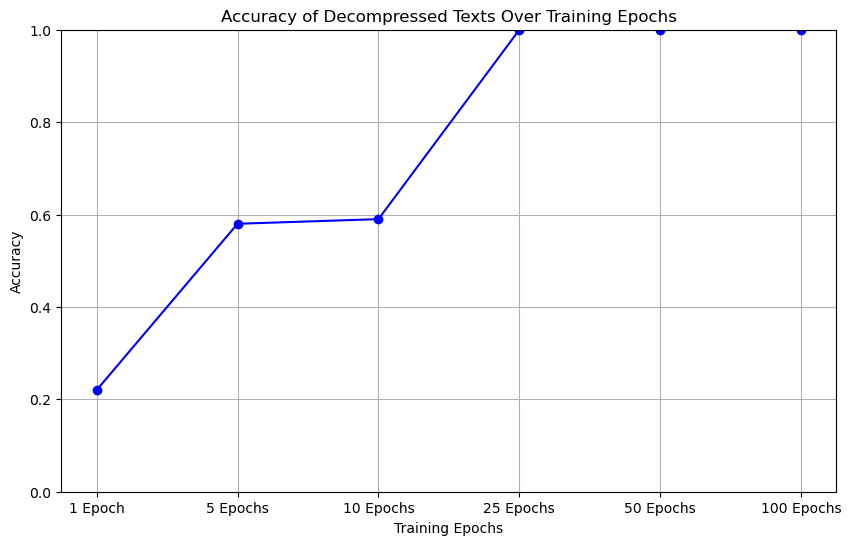

In [56]:
num_samples = 100
compressed_texts = []
original_texts = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for _ in range(num_samples):
    random_index = random.randint(0, len(text_data) - 1)
    original_text = text_data[random_index]
    compressed_text = advanced_compress_text(original_text, tokenizer, model)
    compressed_texts.append(compressed_text)
    original_texts.append(original_text)

print(compressed_texts)

model_names = ['Othello_bert1', 'Othello_bert5', 'Othello_bert10', 'Othello_bert25', 'Othello_bert50', 'Othello_bert100']
accuracies = {}

for model_name in model_names:
    decompressed_texts, sample_accuracies = decompress_texts_for_model(model_name, compressed_texts, original_texts)
    print(f"Model: {model_name}")
    for original, decompressed in zip(original_texts, decompressed_texts):
        print(f"Original: {original}")
        print(f"Decompressed: {decompressed}")
        print(f"Correct: {original == decompressed}")
        print()

    accuracy = sum(sample_accuracies) / len(sample_accuracies)
    accuracies[model_name] = accuracy

print(accuracies)

import matplotlib.pyplot as plt

epochs = ['1 Epoch', '5 Epochs', '10 Epochs', '25 Epochs', '50 Epochs', '100 Epochs'] 
accuracy_values = list(accuracies.values())

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy_values, marker='o', linestyle='-', color='b')
plt.title('Accuracy of Decompressed Texts Over Training Epochs')
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid(True)
plt.show()

### Size Comparison

Since our sample dataset currently is too small to benefit from GZIP compression (it's already smaller than the minimum block size), we'll train quickly on a random wikipedia dataset. This will also ensure fairness, as GZIP would have an unfair advantage with the current sentence structures that reference the same words (fox) multiple times.

In [86]:
from transformers import BertTokenizer, BertForMaskedLM, Trainer, TrainingArguments, TrainerCallback
from transformers import DataCollatorForLanguageModeling
from torch.utils.data import DataLoader
import torch
import random
import os

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForMaskedLM.from_pretrained('bert-base-cased')

# Read the Othello text data from file
with open('wiki.txt', 'r', encoding='utf-8') as file:
    text_data = file.read().splitlines()
    # Only read the first 100 lines
    # text_data = text_data[:10]

# Tokenize all texts
inputs = tokenizer(text_data, return_tensors="pt", max_length=512, truncation=True, padding="max_length", return_attention_mask=True)

# Use a data collator for MLM
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

# Create a torch dataset
class OthelloData(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

dataset = OthelloData(inputs)

# Print some examples
print(tokenizer.decode(dataset[0]['input_ids']))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[CLS] The Order of Brothelyngham was a group of men who, in the mid - 14th century, formed themselves into a fake religious order in the city of Exeter, Devon. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

/tmp/ipykernel_154/20831761.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [89]:
class SaveModelCallback(TrainerCallback):
    def __init__(self, save_steps):
        super().__init__()
        self.save_steps = save_steps

    def on_epoch_end(self, args, state, control, **kwargs):
        if state.epoch in self.save_steps:
            epoch = int(state.epoch)
            model_path = f"./Wiki_bert{epoch}"
            os.makedirs(model_path, exist_ok=True)
            kwargs['model'].save_pretrained(model_path)
            print(f"Model saved to {model_path} at epoch {epoch}")

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1000,  # max epochs
    per_device_train_batch_size=8,
    logging_dir='./logs',
    logging_steps=10,
)

model = BertForMaskedLM.from_pretrained('bert-base-cased')

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
    callbacks=[SaveModelCallback(save_steps=[1, 3, 5, 10, 25, 50, 100,250,500,1000])],  # epochs to save
)

trainer.train()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate

Step,Training Loss
10,1.941400
20,1.991700
30,1.772600
40,1.250500
50,0.992000
60,0.849000
70,0.779800
80,0.673400
90,0.361600
100,0.657000


Model saved to ./Wiki_bert1 at epoch 1


/tmp/ipykernel_154/20831761.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Model saved to ./Wiki_bert3 at epoch 3


/tmp/ipykernel_154/20831761.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Model saved to ./Wiki_bert5 at epoch 5


/tmp/ipykernel_154/20831761.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Model saved to ./Wiki_bert10 at epoch 10


/tmp/ipykernel_154/20831761.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Model saved to ./Wiki_bert25 at epoch 25


/tmp/ipykernel_154/20831761.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Model saved to ./Wiki_bert50 at epoch 50


/tmp/ipykernel_154/20831761.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Model saved to ./Wiki_bert100 at epoch 100


/tmp/ipykernel_154/20831761.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/tmp/ipykernel_154/20831761.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Model saved to ./Wiki_bert250 at epoch 250


/tmp/ipykernel_154/20831761.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/tmp/ipykernel_154/20831761.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Model saved to ./Wiki_bert500 at epoch 500


/tmp/ipykernel_154/20831761.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_154/20831761.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_154/20831761.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Model saved to ./Wiki_bert1000 at epoch 1000


TrainOutput(global_step=3000, training_loss=0.10401309511248837, metrics={'train_runtime': 592.5953, 'train_samples_per_second': 28.687, 'train_steps_per_second': 5.062, 'total_flos': 4474402123776000.0, 'train_loss': 0.10401309511248837, 'epoch': 1000.0})

['The [MASK]appears to have named itself after a non - existent [MASK], " Brothelyngham " .', 'The Order of Brothelyngham was a group of [MASK]who , in the mid-14th century , [MASK]themselves into a fake religious [MASK]in the [MASK]of Exeter , Devon .', 'According to Pinchot , " He [MASK]to my son , Giff , and was [MASK]by the [MASK]that he was anybody \'s and everybody \'s [MASK]. "', "Pep [MASK]the Pinchot [MASK]at Grey Towers residence in Milford , Pennsylvania , during the governor 's first [MASK].", "Pep joined the Pinchot [MASK]at Grey Towers residence in Milford , Pennsylvania , during the governor 's [MASK][MASK] .", 'Such a name would have suggested chaos , wretchedness or some [MASK][MASK] to contemporaries , rather than its [MASK]connotation with a brothel .', 'The [MASK]appears to have named itself after a non - existent [MASK], " Brothelyngham " .', 'Tales of [MASK]and [MASK]not living according to their religious vows were widespread .', 'The low then [MASK]over the Atla

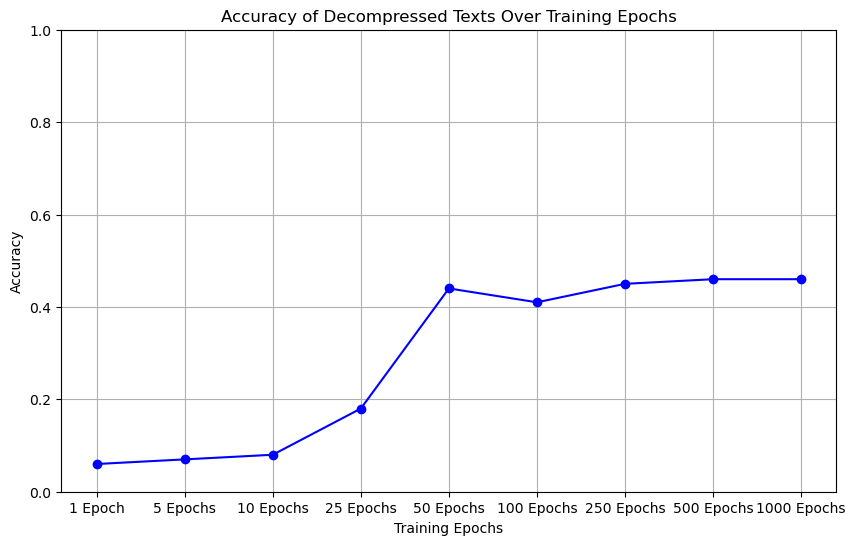

In [90]:
num_samples = 100
compressed_texts = []
original_texts = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for _ in range(num_samples):
    random_index = random.randint(0, len(text_data) - 1)
    original_text = text_data[random_index]
    compressed_text = advanced_compress_text(original_text, tokenizer, model)
    compressed_texts.append(compressed_text)
    original_texts.append(original_text)

print(compressed_texts)

model_names = ['Wiki_bert1', 'Wiki_bert5', 'Wiki_bert10', 'Wiki_bert25', 'Wiki_bert50', 'Wiki_bert100','Wiki_bert250','Wiki_bert500','Wiki_bert1000']
accuracies = {}

for model_name in model_names:
    decompressed_texts, sample_accuracies = decompress_texts_for_model(model_name, compressed_texts, original_texts)
    print(f"Model: {model_name}")
    for original, decompressed in zip(original_texts, decompressed_texts):
        print(f"Original: {original}")
        print(f"Decompressed: {decompressed}")
        print(f"Correct: {original == decompressed}")
        print()

    accuracy = sum(sample_accuracies) / len(sample_accuracies)
    accuracies[model_name] = accuracy

print(accuracies)

import matplotlib.pyplot as plt

epochs = ['1 Epoch', '5 Epochs', '10 Epochs', '25 Epochs', '50 Epochs', '100 Epochs','250 Epochs','500 Epochs','1000 Epochs']  # Assuming these correspond to your models
accuracy_values = list(accuracies.values())

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy_values, marker='o', linestyle='-', color='b')
plt.title('Accuracy of Decompressed Texts Over Training Epochs')
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid(True)
plt.show()

In [94]:
import gzip
import io

def compress_text_gzip(text):
    """
    Compress text using gzip and return the compressed data size in bytes.
    """
    with io.BytesIO() as bytes_io:
        with gzip.GzipFile(fileobj=bytes_io, mode='w') as gzip_file:
            gzip_file.write(text.encode('utf-8'))
        return len(bytes_io.getvalue())

def calculate_compression_ratios(text, tokenizer, model):
    # Raw text size
    raw_size = len(text.encode('utf-8'))
    # GZIP size
    gzip_raw_size = compress_text_gzip(text)

    compressed_text = advanced_compress_text(text, tokenizer, model)
    print(compressed_text)

    # Replace [MASK] tokens with 1 character 
    compressed_text = compressed_text.replace('[MASK]', '~')
    # GZIP size of the model's compressed text
    gzip_compressed_size = compress_text_gzip(compressed_text)
    
    return {
        'raw_size': raw_size,
        'gzip_raw_size': gzip_raw_size,
        'gzip_compressed_size': gzip_compressed_size
    }


# Split text data into three parts
new_text_data = []
new_text_data.append(' '.join(text_data[:6]))
new_text_data.append(' '.join(text_data[6:10]))
new_text_data.append(' '.join(text_data[10:14]))

compressed_results = []
for text in new_text_data:
    compression_results = calculate_compression_ratios(text, tokenizer, model)
    print(compression_results)
    compressed_results.append(compression_results)


The Order of Brothelyngham was a group of [MASK]who , in the mid-14th century , [MASK]themselves into a fake religious [MASK]in the [MASK]of Exeter , Devon . They may well have been satirising the church , which was commonly perceived as corrupt . Tales of priests and nuns not living according to their religious vows were widespread . The [MASK][MASK] to have named itself after a [MASK]- existent [MASK], " Brothelyngham " . Such a [MASK]would have [MASK][MASK] , [MASK]or some [MASK][MASK] to contemporaries , rather than its modern connotation with a [MASK]. The men of this fake [MASK]dressed as [MASK], and supposedly elected a madman to [MASK]them as their [MASK], possibly from a [MASK]stage or throne .
{'raw_size': 708, 'gzip_raw_size': 429, 'gzip_compressed_size': 377}
Pep was a Labrador Retriever born around 1923 and given as a [MASK]to Pennsylvania governor Gifford Pinchot from the [MASK]of his [MASK], Cornelia Bryce Pinchot . [MASK]joined the Pinchot [MASK]at Grey Towers [MASK]in 

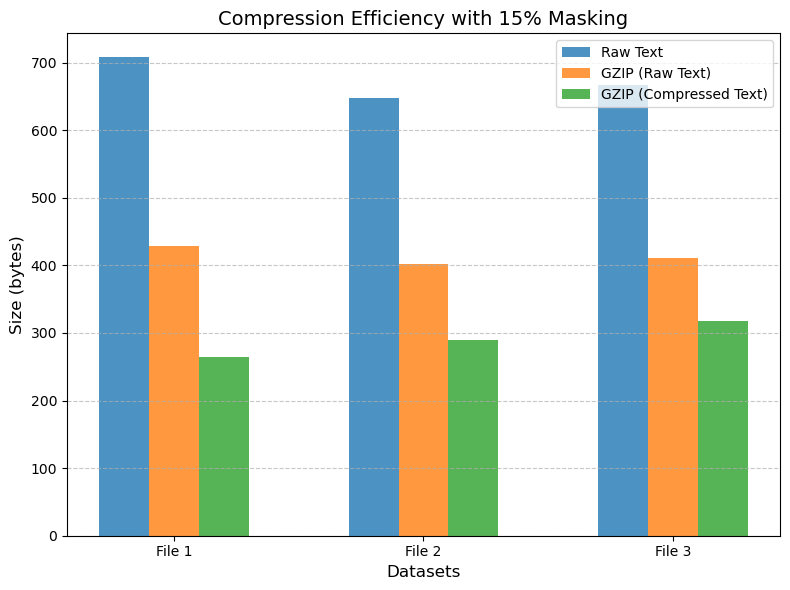

In [105]:
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.2
opacity = 0.8

index = range(len(new_text_data))

raw_sizes = [result['raw_size'] for result in compressed_results]
gzip_raw_sizes = [result['gzip_raw_size'] for result in compressed_results]
gzip_compressed_sizes = [result['gzip_compressed_size'] for result in compressed_results]

plt.bar(index, raw_sizes, bar_width, alpha=opacity, color='#1f77b4', label='Raw Text')
plt.bar([i + bar_width for i in index], gzip_raw_sizes, bar_width, alpha=opacity, color='#ff7f0e', label='GZIP (Raw Text)')
plt.bar([i + 2 * bar_width for i in index], gzip_compressed_sizes, bar_width, alpha=opacity, color='#2ca02c', label='GZIP (Compressed Text)')

plt.xlabel('Datasets', fontsize=12)
plt.ylabel('Size (bytes)', fontsize=12)
plt.title('Compression Efficiency with 15% Masking', fontsize=14)
plt.xticks([i + bar_width for i in index], ['File 1', 'File 2', 'File 3'], fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('compression_efficiency.png', dpi=300)
plt.show()

['Tales of [MASK]and [MASK]not [MASK][MASK] to their [MASK][MASK] were [MASK].', 'While the [MASK][MASK] across the Gulf , [MASK][MASK] [MASK]with the [MASK][MASK] down across Texas , Louisiana , and Florida , ultimately [MASK]in ten [MASK].', 'While the [MASK][MASK] across the Gulf , [MASK][MASK] [MASK]with the [MASK][MASK] down across Texas , Louisiana , and Florida , ultimately [MASK]in ten [MASK].', 'The [MASK]then [MASK]northward while [MASK][MASK] [MASK]and [MASK][MASK] across [MASK]of the Mid - Atlantic on February 11 , [MASK]across Maryland and [MASK]Virginia .', 'Overall , the [MASK][MASK] 46 [MASK]and set [MASK][MASK] [MASK]in [MASK]of [MASK].', '[MASK] to Pinchot , " He [MASK]to my [MASK], Giff , and was [MASK]by the [MASK]that he was anybody \'s and everybody \'s [MASK]. "', 'The Order of Brothelyngham was a [MASK]of [MASK]who , in the mid-14th [MASK], [MASK]themselves into a [MASK][MASK] [MASK]in the [MASK]of Exeter , Devon .', 'The [MASK][MASK] to have [MASK]itself after 

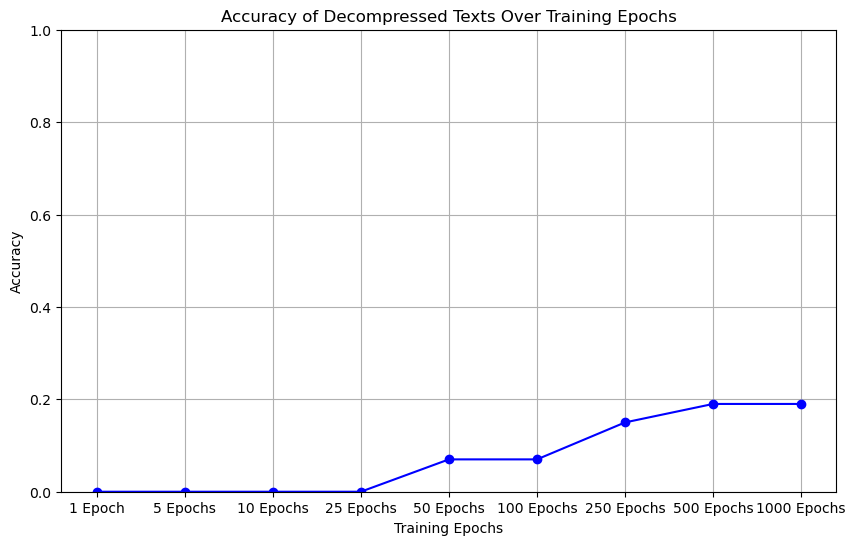

In [100]:
num_samples = 100
compressed_texts = []
original_texts = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for _ in range(num_samples):
    random_index = random.randint(0, len(text_data) - 1)
    original_text = text_data[random_index]
    compressed_text = advanced_compress_text(original_text, tokenizer, model, mask_ratio=0.5)
    compressed_texts.append(compressed_text)
    original_texts.append(original_text)

print(compressed_texts)

model_names = ['Wiki_bert1', 'Wiki_bert5', 'Wiki_bert10', 'Wiki_bert25', 'Wiki_bert50', 'Wiki_bert100','Wiki_bert250','Wiki_bert500','Wiki_bert1000']
accuracies = {}

for model_name in model_names:
    decompressed_texts, sample_accuracies = decompress_texts_for_model(model_name, compressed_texts, original_texts)
    print(f"Model: {model_name}")
    for original, decompressed in zip(original_texts, decompressed_texts):
        print(f"Original: {original}")
        print(f"Decompressed: {decompressed}")
        print(f"Correct: {original == decompressed}")
        print()

    accuracy = sum(sample_accuracies) / len(sample_accuracies)
    accuracies[model_name] = accuracy

print(accuracies)

import matplotlib.pyplot as plt

epochs = ['1 Epoch', '5 Epochs', '10 Epochs', '25 Epochs', '50 Epochs', '100 Epochs','250 Epochs','500 Epochs','1000 Epochs']
accuracy_values = list(accuracies.values())

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy_values, marker='o', linestyle='-', color='b')
plt.title('Accuracy of Decompressed Texts Over Training Epochs')
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid(True)
plt.show()

In [102]:
new_text_data = []
new_text_data.append(' '.join(text_data[:6]))
new_text_data.append(' '.join(text_data[6:10]))
new_text_data.append(' '.join(text_data[10:14]))

compressed_results = []
for text in new_text_data:
    compression_results = calculate_compression_ratios(text, tokenizer, model, mask_ratio=0.5)
    print(compression_results)
    compressed_results.append(compression_results)


The Order of Brothelyngham was a [MASK]of [MASK]who , in the mid-14th [MASK], [MASK]themselves into a [MASK][MASK] [MASK]in the [MASK]of Exeter , Devon . They may well have been [MASK]the [MASK], which was commonly [MASK]as [MASK]. [MASK]of [MASK]and [MASK]not [MASK][MASK] to their [MASK][MASK] were [MASK]. The [MASK][MASK] to have [MASK]itself after a [MASK][MASK] [MASK][MASK] , " Brothelyngham " . Such a [MASK]would have [MASK][MASK] , [MASK]or some [MASK][MASK] to [MASK], rather than its [MASK][MASK] with a [MASK]. The [MASK]of this [MASK][MASK] [MASK]as [MASK], and supposedly [MASK]a [MASK]to [MASK]them as their [MASK], possibly from a [MASK][MASK] or [MASK].
{'raw_size': 708, 'gzip_raw_size': 429, 'gzip_compressed_size': 264}
Pep was a Labrador Retriever [MASK]around 1923 and [MASK]as a [MASK]to Pennsylvania [MASK]Gifford Pinchot from the [MASK]of his [MASK], Cornelia Bryce Pinchot . [MASK][MASK] the Pinchot [MASK]at Grey Towers [MASK]in Milford , Pennsylvania , during the [MASK]'

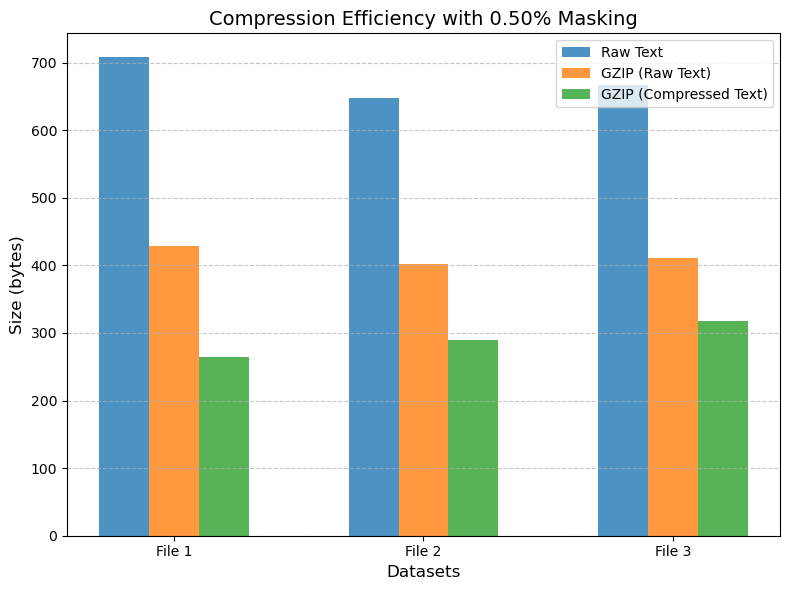

In [104]:
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.2
opacity = 0.8

index = range(len(new_text_data))

raw_sizes = [result['raw_size'] for result in compressed_results]
gzip_raw_sizes = [result['gzip_raw_size'] for result in compressed_results]
gzip_compressed_sizes = [result['gzip_compressed_size'] for result in compressed_results]

plt.bar(index, raw_sizes, bar_width, alpha=opacity, color='#1f77b4', label='Raw Text')
plt.bar([i + bar_width for i in index], gzip_raw_sizes, bar_width, alpha=opacity, color='#ff7f0e', label='GZIP (Raw Text)')
plt.bar([i + 2 * bar_width for i in index], gzip_compressed_sizes, bar_width, alpha=opacity, color='#2ca02c', label='GZIP (Compressed Text)')

plt.xlabel('Datasets', fontsize=12)
plt.ylabel('Size (bytes)', fontsize=12)
plt.title('Compression Efficiency with 50% Masking', fontsize=14)
plt.xticks([i + bar_width for i in index], ['File 1', 'File 2', 'File 3'], fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('compression_efficiency.png', dpi=300)
plt.show()